In [8]:
import matplotlib.pyplot as plt
import numpy as np
import PIL
import tensorflow as tf

from tensorflow import keras
from keras import layers
from keras.models import Sequential

import pathlib

import os

*/*.JPG, */*.jpg and */*.* all return different values, meaning the dataset has different file types

In [9]:
data_dir = pathlib.Path('plantvillage-plantix')

folders = os.listdir(data_dir)

image_count = len(list(data_dir.glob('*/*.*')))
print(image_count)


18030


In [10]:
bacterial_spot = list(data_dir.glob('Tomato___Bacterial_spot/*'))
early_blight = list(data_dir.glob('Tomato___Early_blight/*'))
healthy = list(data_dir.glob('Tomato___healthy/*'))
late_blight = list(data_dir.glob('Tomato___Late_blight/*'))
leaf_mold = list(data_dir.glob('Tomato___Leaf_Mold/*'))
septoria_leaf_spot = list(data_dir.glob('Tomato___Septoria_leaf_spot/*'))
spider_mites = list(data_dir.glob('Tomato___Spider_mites Two-spotted_spider_mite/*'))
target_spot = list(data_dir.glob('Tomato___Target_Spot/*'))
mosaic = list(data_dir.glob('Tomato___Tomato_mosaic_virus/*'))
yellow_leaf_curl = list(data_dir.glob('Tomato___Tomato_Yellow_Leaf_Curl_Virus/*'))

# for img in yellow_leaf_curl:
#     arr = np.array(PIL.Image.open(img))
#     if not (arr.shape == (256, 256, 3)):
#         raise Exception

for subdir in list(data_dir.glob('*')):
    print(subdir)
    print(len(list(subdir.glob('*'))))
    imgs = list(subdir.glob('*'))
    # PIL.Image.open(str(imgs[0]))

plantvillage-plantix/Tomato___Bacterial_spot
2129
plantvillage-plantix/Tomato___Early_blight
1002
plantvillage-plantix/Tomato___Late_blight
1910
plantvillage-plantix/Tomato___Leaf_Mold
1002
plantvillage-plantix/Tomato___Septoria_leaf_spot
1772
plantvillage-plantix/Tomato___Spider_mites Two-spotted_spider_mite
1679
plantvillage-plantix/Tomato___Target_Spot
1404
plantvillage-plantix/Tomato___Tomato_Yellow_Leaf_Curl_Virus
5361
plantvillage-plantix/Tomato___Tomato_mosaic_virus
1002
plantvillage-plantix/Tomato___healthy
769


In [11]:
batch_size = 32
img_height = 180
img_width = 180

train_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="training",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

val_ds = tf.keras.utils.image_dataset_from_directory(
  data_dir,
  validation_split=0.2,
  subset="validation",
  seed=123,
  image_size=(img_height, img_width),
  batch_size=batch_size)

Found 18030 files belonging to 10 classes.
Using 14424 files for training.


2023-02-06 17:15:54.684455: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory
2023-02-06 17:15:54.684495: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-02-06 17:15:54.684517: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (vedkm-foliagefixermode-l8v7u6tacyt): /proc/driver/nvidia/version does not exist
2023-02-06 17:15:54.684843: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 18030 files belonging to 10 classes.
Using 3606 files for validation.


In [12]:
class_names = train_ds.class_names
print(class_names)

['Tomato___Bacterial_spot', 'Tomato___Early_blight', 'Tomato___Late_blight', 'Tomato___Leaf_Mold', 'Tomato___Septoria_leaf_spot', 'Tomato___Spider_mites Two-spotted_spider_mite', 'Tomato___Target_Spot', 'Tomato___Tomato_Yellow_Leaf_Curl_Virus', 'Tomato___Tomato_mosaic_virus', 'Tomato___healthy']


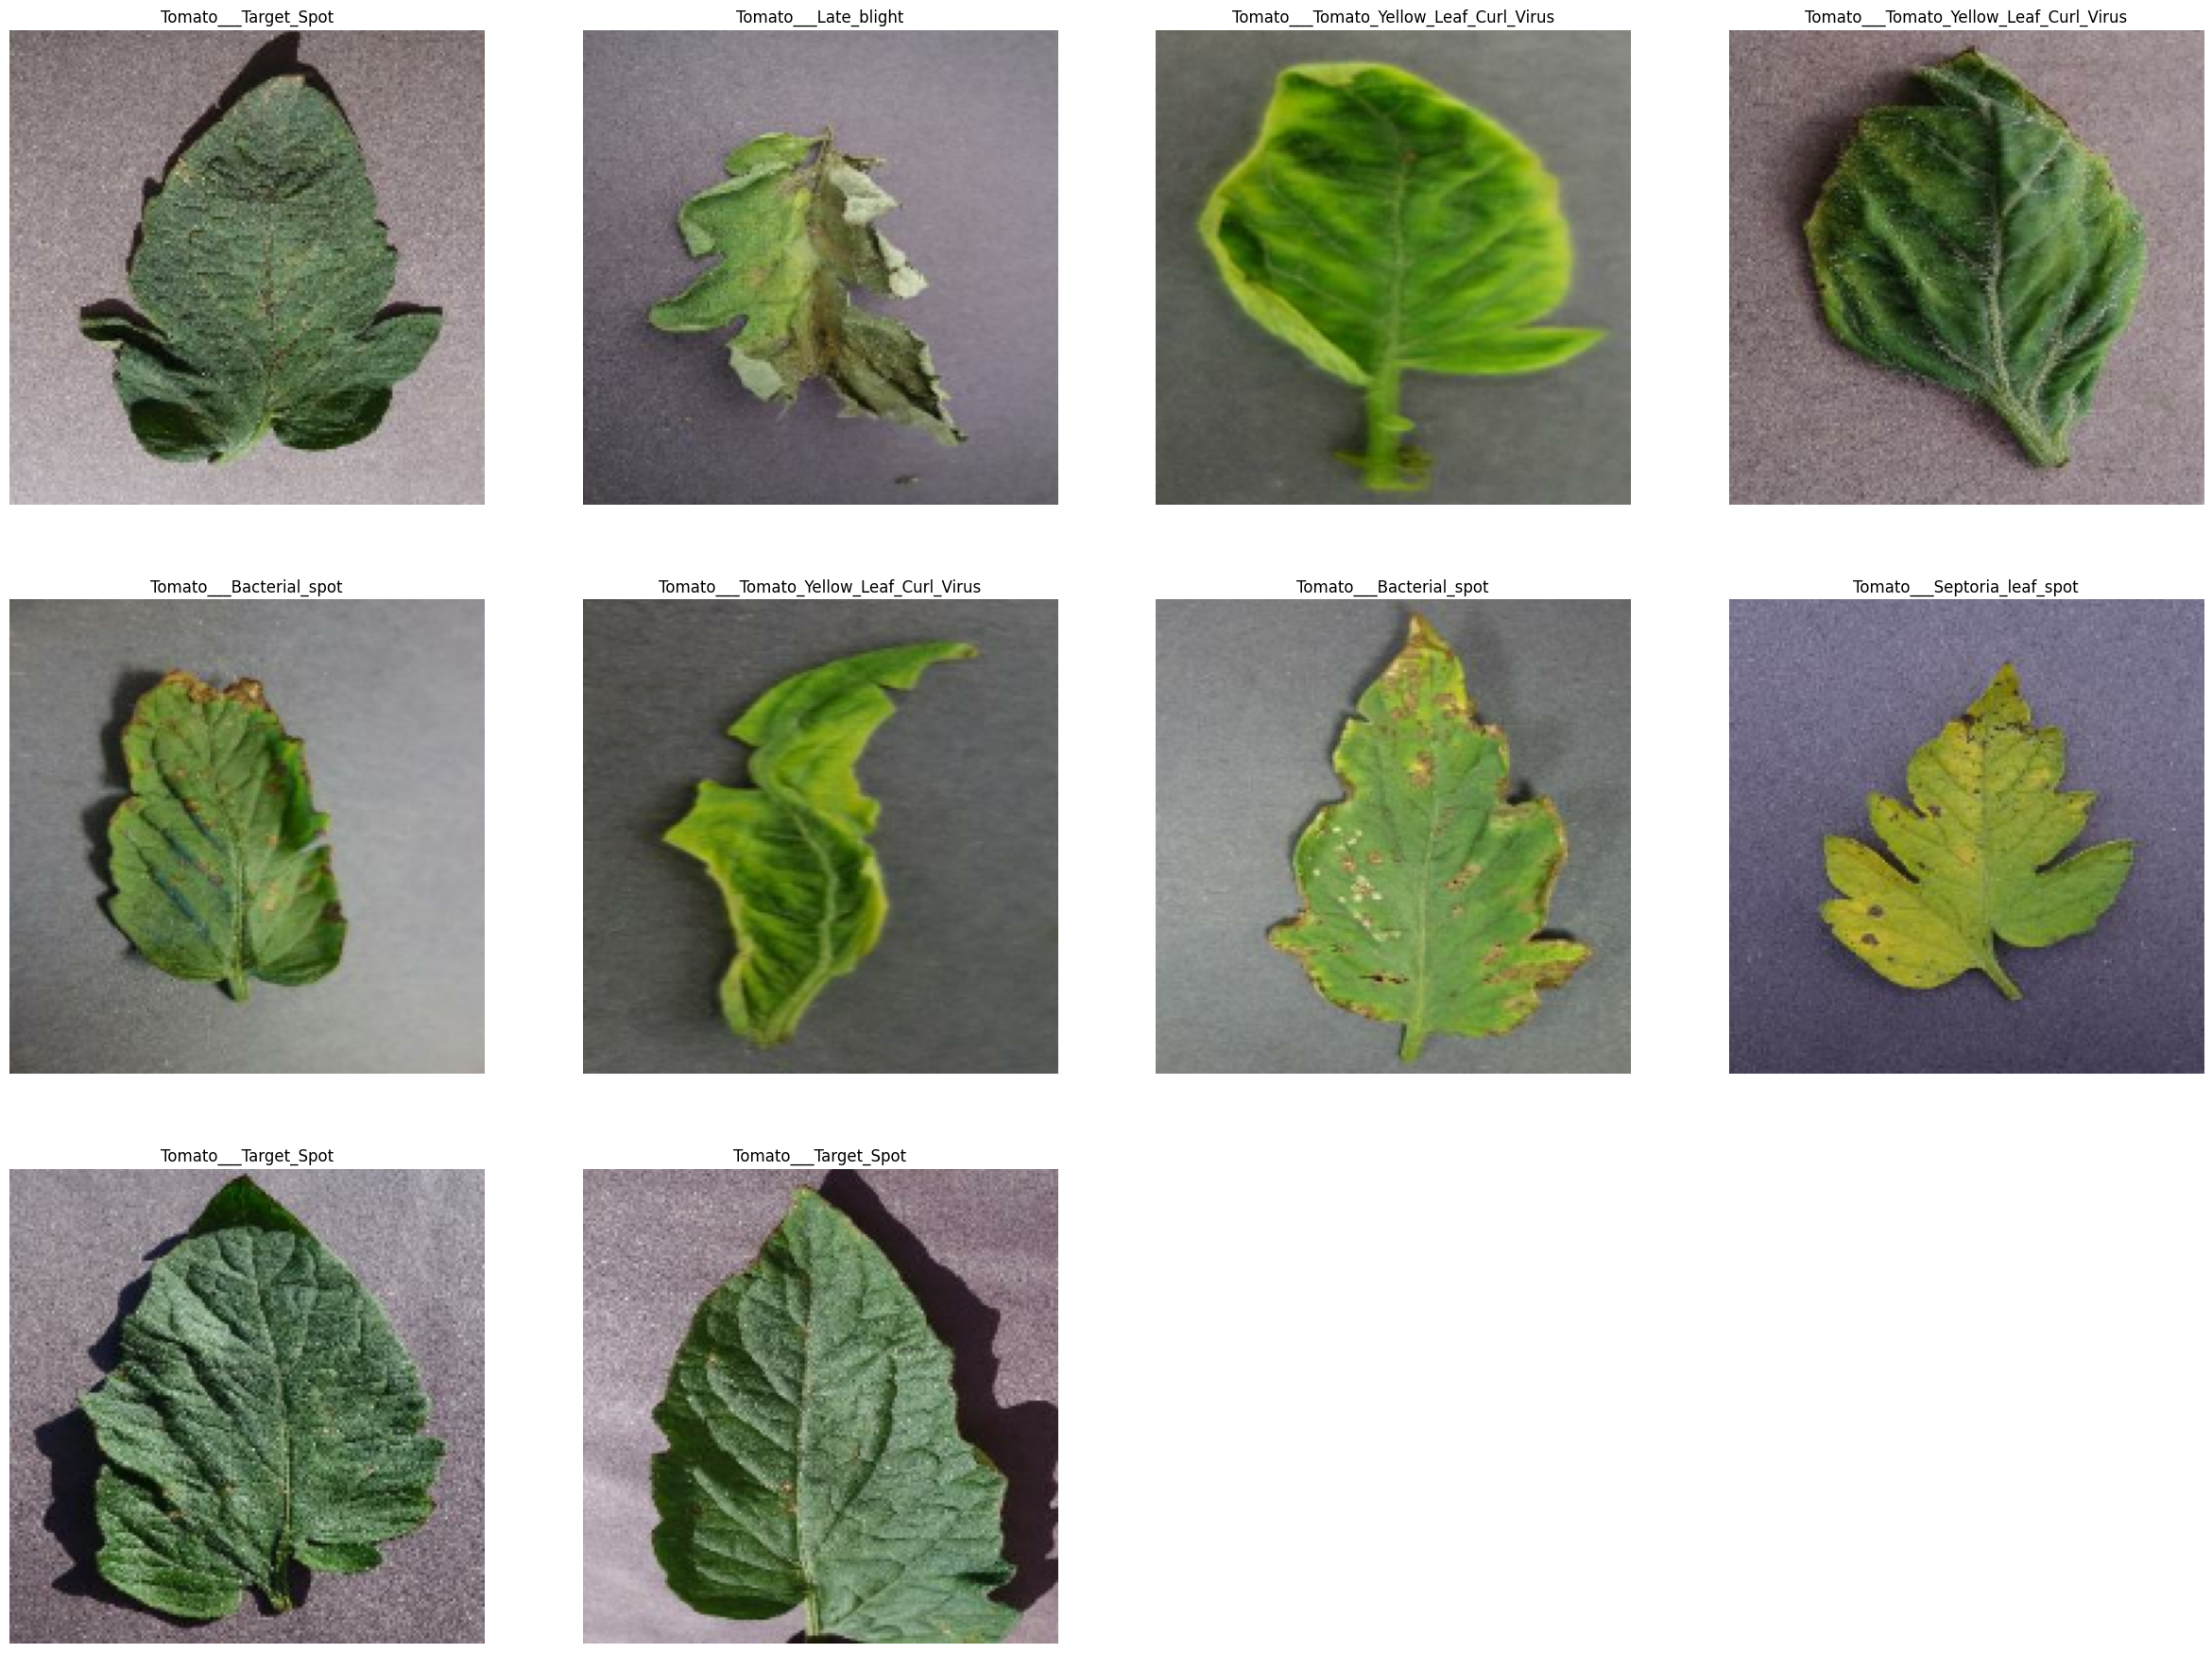

In [13]:
plt.figure(figsize=(30, 30))
for images, labels in train_ds.take(1):
  for i in range(10):
    ax = plt.subplot(4, 4, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [14]:
for image_batch, labels_batch in train_ds:
  print(image_batch.shape)
  print(labels_batch.shape)
  break

(32, 180, 180, 3)
(32,)


In [15]:
AUTOTUNE = tf.data.AUTOTUNE

train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [16]:
normalization_layer = layers.Rescaling(scale=1./255)

normalized_ds = train_ds.map(lambda x, y: (normalization_layer(x), y))
image_batch, labels_batch = next(iter(normalized_ds))
first_image = image_batch[0]
# Notice the pixel values are now in `[0,1]`.
print(np.min(first_image), np.max(first_image))

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089
9.0049536e-05 0.76794374


In [17]:
data_augmentation = keras.Sequential(
  [
    layers.RandomFlip("horizontal",
                      input_shape=(img_height,
                                  img_width,
                                  3)),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
  ]
)

In [18]:
num_classes = len(class_names)

model = Sequential([
  data_augmentation,
  layers.Rescaling(1./255, input_shape=(img_height, img_width, 3)),
  layers.Conv2D(16, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(32, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Conv2D(64, 3, padding='same', activation='relu'),
  layers.MaxPooling2D(),
  layers.Dropout(0.2), #or 0.2
  layers.Flatten(),
  layers.Dense(128, activation='relu'),
  layers.Dense(num_classes)
])

# model = Sequential()
# inputShape = (img_height, img_width, 3)
# chanDim = -1 #or -1
# model.add(layers.Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
# model.add(layers.Activation("relu"))
# model.add(layers.BatchNormalization(axis=chanDim))
# model.add(layers.MaxPooling2D(pool_size=(3, 3)))
# model.add(layers.Dropout(0.25))
# model.add(layers.Conv2D(64, (3, 3), padding="same"))
# model.add(layers.Activation("relu"))
# model.add(layers.BatchNormalization(axis=chanDim))
# model.add(layers.Conv2D(64, (3, 3), padding="same"))
# model.add(layers.Activation("relu"))
# model.add(layers.BatchNormalization(axis=chanDim))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(layers.Dropout(0.25))
# model.add(layers.Conv2D(128, (3, 3), padding="same"))
# model.add(layers.Activation("relu"))
# model.add(layers.BatchNormalization(axis=chanDim))
# model.add(layers.Conv2D(128, (3, 3), padding="same"))
# model.add(layers.Activation("relu"))
# model.add(layers.BatchNormalization(axis=chanDim))
# model.add(layers.MaxPooling2D(pool_size=(2, 2)))
# model.add(layers.Dropout(0.25))
# model.add(layers.Flatten())
# model.add(layers.Dense(1024))
# model.add(layers.Activation("relu"))
# model.add(layers.BatchNormalization())
# model.add(layers.Dropout(0.5))
# model.add(layers.Dense(num_classes))

In [19]:
model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [20]:
epochs=10
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs
)

Epoch 1/10
451/451 [==============================] - 110s 236ms/step - loss: 1.0069 - accuracy: 0.6579 - val_loss: 0.7921 - val_accuracy: 0.7429
Epoch 2/10
451/451 [==============================] - 105s 233ms/step - loss: 0.5076 - accuracy: 0.8300 - val_loss: 0.9492 - val_accuracy: 0.6991
Epoch 3/10
451/451 [==============================] - 106s 234ms/step - loss: 0.3613 - accuracy: 0.8758 - val_loss: 0.4571 - val_accuracy: 0.8453
Epoch 4/10
451/451 [==============================] - 105s 234ms/step - loss: 0.2931 - accuracy: 0.8977 - val_loss: 0.6857 - val_accuracy: 0.7928
Epoch 5/10
451/451 [==============================] - 108s 239ms/step - loss: 0.2569 - accuracy: 0.9135 - val_loss: 0.7403 - val_accuracy: 0.7884
Epoch 6/10
451/451 [==============================] - 108s 239ms/step - loss: 0.2298 - accuracy: 0.9224 - val_loss: 0.3782 - val_accuracy: 0.8777
Epoch 7/10
451/451 [==============================] - 107s 236ms/step - loss: 0.1961 - accuracy: 0.9323 - val_loss: 0.8706 -

In [21]:
import datetime

# print(str(datetime.datetime.now()))
model.save('saved_model/model'+str(datetime.datetime.now()))

INFO:tensorflow:Assets written to: saved_model/model2023-02-06 17:36:21.839626/assets


INFO:tensorflow:Assets written to: saved_model/model2023-02-06 17:36:21.839626/assets


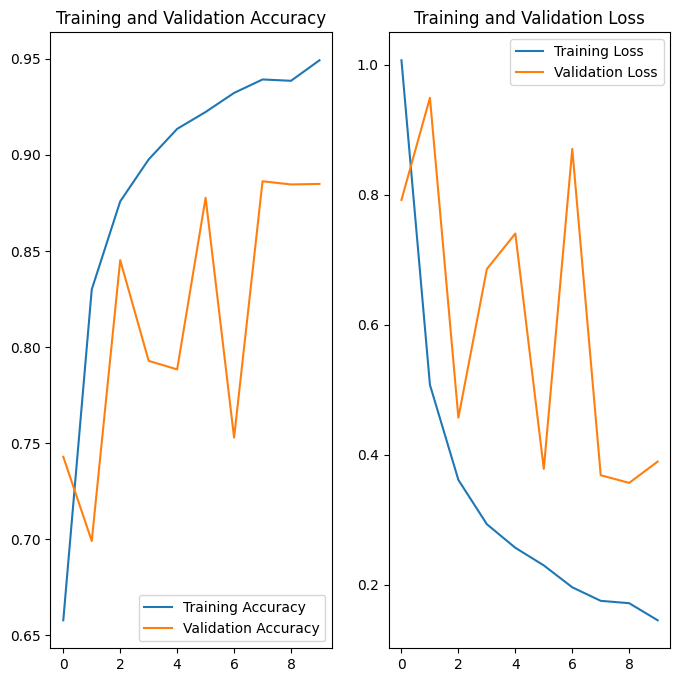

In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(epochs)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [23]:
model.evaluate(val_ds)

113/113 [==============================] - 6s 51ms/step - loss: 0.3895 - accuracy: 0.8849


[0.3894987404346466, 0.8849140405654907]

CLASSIFY NEW DATA

In [27]:
leaf_path = pathlib.Path('leaf-mold-of-tomato-1.jpg')

img = tf.keras.utils.load_img(
    leaf_path, target_size=(img_height, img_width)
)
img_array = tf.keras.utils.img_to_array(img)
img_array = tf.expand_dims(img_array, 0) # Create a batch

predictions = model.predict(img_array)
score = tf.nn.softmax(predictions[0])

print(
    "This image most likely belongs to {} with a {:.2f} percent confidence."
    .format(class_names[np.argmax(score)], 100 * np.max(score))
)

1/1 [==============================] - 0s 20ms/step
This image most likely belongs to Tomato___Late_blight with a 97.95 percent confidence.


In [25]:
10 MORE EPOCHS

SyntaxError: invalid syntax (413381868.py, line 1)

In [ ]:
# epochs=10
# history = model.fit(
#   train_ds,
#   validation_data=val_ds,
#   epochs=epochs
# )

Epoch 1/10
471/471 [==============================] - 111s 235ms/step - loss: 0.1319 - accuracy: 0.9519 - val_loss: 0.5452 - val_accuracy: 0.8569
Epoch 2/10
471/471 [==============================] - 105s 224ms/step - loss: 0.0981 - accuracy: 0.9649 - val_loss: 0.2755 - val_accuracy: 0.9124
Epoch 3/10
471/471 [==============================] - 105s 222ms/step - loss: 0.1090 - accuracy: 0.9617 - val_loss: 0.8804 - val_accuracy: 0.8057
Epoch 4/10
471/471 [==============================] - 140s 298ms/step - loss: 0.1128 - accuracy: 0.9607 - val_loss: 0.2677 - val_accuracy: 0.9225
Epoch 5/10
471/471 [==============================] - 104s 220ms/step - loss: 0.0914 - accuracy: 0.9688 - val_loss: 0.2667 - val_accuracy: 0.9161
Epoch 6/10
471/471 [==============================] - 104s 221ms/step - loss: 0.0849 - accuracy: 0.9697 - val_loss: 0.6385 - val_accuracy: 0.8468
Epoch 7/10
471/471 [==============================] - 105s 222ms/step - loss: 0.0894 - accuracy: 0.9679 - val_loss: 0.3637 -

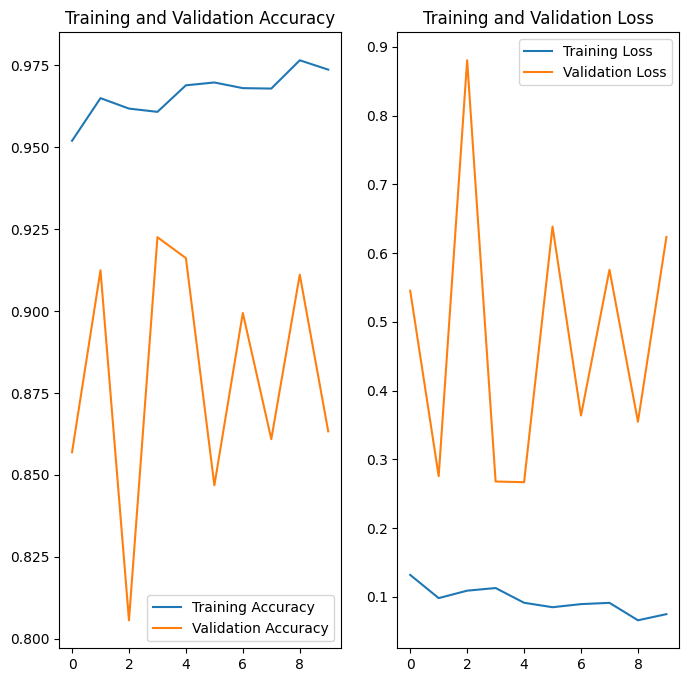

In [ ]:
# acc = history.history['accuracy']
# val_acc = history.history['val_accuracy']

# loss = history.history['loss']
# val_loss = history.history['val_loss']

# epochs_range = range(epochs)

# plt.figure(figsize=(8, 8))
# plt.subplot(1, 2, 1)
# plt.plot(epochs_range, acc, label='Training Accuracy')
# plt.plot(epochs_range, val_acc, label='Validation Accuracy')
# plt.legend(loc='lower right')
# plt.title('Training and Validation Accuracy')

# plt.subplot(1, 2, 2)
# plt.plot(epochs_range, loss, label='Training Loss')
# plt.plot(epochs_range, val_loss, label='Validation Loss')
# plt.legend(loc='upper right')
# plt.title('Training and Validation Loss')
# plt.show()

In [ ]:
# model.evaluate(val_ds)

118/118 [==============================] - 14s 121ms/step - loss: 0.6235 - accuracy: 0.8633


[0.6234539747238159, 0.8632864356040955]

In [ ]:
# leaf_path = pathlib.Path('mosaic2.png')

# img = tf.keras.utils.load_img(
#     leaf_path, target_size=(img_height, img_width)
# )
# img_array = tf.keras.utils.img_to_array(img)
# img_array = tf.expand_dims(img_array, 0) # Create a batch

# predictions = model.predict(img_array)
# score = tf.nn.softmax(predictions[0])

# print(
#     "This image most likely belongs to {} with a {:.2f} percent confidence."
#     .format(class_names[np.argmax(score)], 100 * np.max(score))
# )